In [19]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import sem
import seaborn as sns
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.gridspec as gridspec
%matplotlib inline

import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString
from pyproj import CRS

import json
import time
import itertools
from copy import deepcopy

### Figure 1 - home identification and spatial network projection

In [2]:
# tweets of an example user
tweets = pd.read_csv("../data/example_user_tweets.csv")

# timeline of an example user
hours = pd.read_csv("../data/example_user_timeline.csv")

In [3]:
# the user_id
user_id = tweets['user_id'].unique()[0]

# cluster tweeting activity
weekday_profiles = {}

# for all three clusters
for c in range(3):
    # get the weekday hourly tweetcounts
    hmask = (hours['user_id'] == user_id) & (hours['cluster_id'] == c)
    w = hours[hmask].pivot_table(index='weekday', columns='hour', values='cnt').fillna(0).loc[1:6].sum()

    # normalize (to be able to compare the 5000 tweets to the 200 tweets)
    w = w / w.sum()
    
    # fill up the missing hours
    w2 = np.zeros(24)
    w2[w.index] = w
    
    # creating x,y series for "rectangular" plotting
    x=[]
    y=[]
    for i,elem in enumerate(w2):
        if i==0:
            x.append(i)
            y.append(elem)
            x.append(i+0.5)
            y.append(elem)
        else:
            x.append(i-0.5)
            y.append(elem)
            x.append(i+0.5)
            y.append(elem)
    x.append(23.5)
    y.append(w2[0])            
    x.append(24)
    y.append(w2[0])
    
    # store activity profiles with cluster_id key to dict
    weekday_profiles[c] = x,y

In [ ]:
# follower network edgelist
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')
edgelist = edgelist.loc[edgelist['cbsacode'] == 14460.0]  # Boston only

# data about users
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz')
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "tract_home"]]

# edgelist with geoinfo
edgelist = pd.merge(
    pd.merge(
        edgelist,
        user_geo,
        left_on="user_id1",
        right_on="user_id",
        how="left"
    ),
    user_geo,
    left_on="user_id2",
    right_on="user_id",
    how="left",
    suffixes=("1", "2")
)

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [5]:
# census data IN
census = pd.read_csv('../data/censusdata_top50_2012.csv')

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census['geoid'] = census.apply(create_geoid, axis=1)

# keep income ONLY
census = census.loc[:,["geoid", "income"]]

In [ ]:
# census data IN
census = pd.read_csv('../data/censusdata_top50_2012.csv')

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census['geoid'] = census.apply(create_geoid, axis=1)

# keep income ONLY
census = census.loc[:,["geoid", "income"]]

## add cbsacodes to census tract level dataframe
temp = userinfo.loc[:,['cbsacode', 'tract_home']].drop_duplicates()

# merge cbsacodes
census = pd.merge(
    census,
    userinfo[["cbsacode", "tract_home"]].drop_duplicates(),
    left_on="geoid",
    right_on="tract_home",
    how="left"
)
census = census.drop(columns=("tract_home"))

# further filters
census = census[(census['income'] > 0)]

# remove NAs...
census = census.dropna()

# median income by cbsacode
census['income_median'] = census['cbsacode'].map(census.groupby('cbsacode')['income'].median().to_dict())
lo = (census['income'] < census["income_median"])
census['low'] = lo.astype(int).fillna(0)

In [ ]:
# geojson data, converted to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# projections
init_crs = 4326
project_crs = 3857

# possibly projecting census tract geometries into the same Cartesian coordinate system as the user coordinates would work like
tract_geoms.crs = {'init': 'epsg:' + str(init_crs)}
tract_geoms.to_crs(epsg = init_crs, inplace=True)

# creating spatial index
tract_si = tract_geoms.sindex

# merge
tract_geoms = pd.merge(
    tract_geoms,
    census,
    left_on='full_geoid',
    right_on="geoid",
    how="left"
)

In [ ]:
# focal user from high income area
focal_user = edgelist[edgelist["user_id1"]==6160022]
focal_user = focal_user[(focal_user["lat_home2"]>42.2) & (focal_user["lat_home2"]<42.45)]

# point of home
point_home = focal_user[['lon_home1', 'lat_home1']].drop_duplicates()
point_home['focal_home'] = point_home.apply(lambda row: Point(row['lon_home1'], row['lat_home1']), axis = 1)
point_home = point_home.set_geometry('focal_home')

# projection change
point_home.crs = {'init': 'epsg:4326'}

# create geodataframe with lines = edges between home locations
lines_home = deepcopy(focal_user)
lines_home['geometry_home_edges'] = lines_home.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
lines_home = gpd.GeoDataFrame(lines_home).set_geometry('geometry_home_edges')

# projection change
lines_home.crs = {'init': 'epsg:4326'}

# point of friends
friend_homes = lines_home[['lon_home2', 'lat_home2']]
friend_homes['geometry_friend_home'] = friend_homes.apply(lambda row: Point(row['lon_home2'], row['lat_home2']), axis = 1)
friend_homes = friend_homes.set_geometry('geometry_friend_home')

# projection change
friend_homes.crs = {'init': 'epsg:4326'}

# list of friends
friends = set(list(focal_user['user_id2']))

# third ties
friend_table = edgelist[(edgelist['user_id1'].isin(friends)) & (edgelist['user_id2'].isin(friends))]
friend_table['geometry_third'] = friend_table.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
friend_table = gpd.GeoDataFrame(friend_table).set_geometry('geometry_third')

# projection change
friend_table.crs = {'init': 'epsg:4326'}

In [11]:
# keep only Boston census tracts
boston_bbox = {"lonmin":-71.55,"latmin":42.1,"lonmax":-70.9,"latmax":42.55}
boston_bbox_poly = Polygon([[boston_bbox["lonmin"],boston_bbox["latmin"]],
                   [boston_bbox["lonmax"],boston_bbox["latmin"]],
                   [boston_bbox["lonmax"],boston_bbox["latmax"]],
                   [boston_bbox["lonmin"],boston_bbox["latmax"]]])
boston_geoms = tract_geoms[tract_geoms.geometry.within(boston_bbox_poly)] #.to_crs({'init' : 'epsg:4326'})

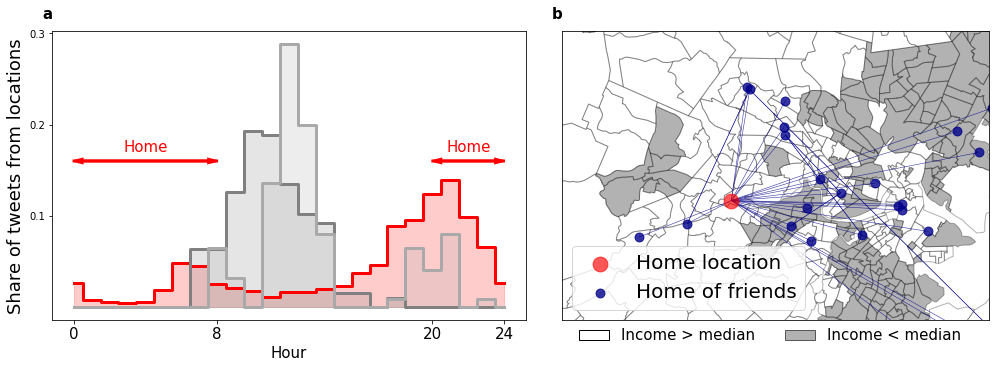

In [12]:
# Fig1 plot
fig, ax = plt.subplots(1, 2, figsize = (14, 5), constrained_layout=True)
plt.rcParams['font.size']=15

# timeline histograms
for c,hatch,color in zip([0,1,2],['x','o','//'],["red","grey","darkgrey"]):
    ax[0].plot(*weekday_profiles[c], color=color, lw=3)
    ax[0].fill_between(*weekday_profiles[c],color=color, label=r'Location '+str(c+1)+' timeline', alpha=0.2)
ax[0].set_xlabel('Hour', size=15)

# home delimiters
ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].xaxis.set_ticks([0,8,20,24])

# y axis setting
ax[0].yaxis.set_ticks([0.1, 0.2, 0.3])
ax[0].set_ylabel('Share of tweets from locations', size=18)

# mark home time span
ax[0].arrow(0,0.16,8,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].arrow(8,0.16,-8,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].annotate('Home',(4,0.175),color='red',ha='center',va='center')

ax[0].arrow(20,0.16,4,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].arrow(24,0.16,-4,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].annotate('Home',(22,0.175),color='red',ha='center',va='center')

# map
boston_geoms.plot(ax=ax[1], column = 'low', cmap='Greys', edgecolor = 'black', alpha=0.3)

# home point
point_home.plot(ax=ax[1], color='red', marker='o', markersize=220, alpha=0.65, zorder=3, label = 'Home location')

# edges
lines_home.plot(ax=ax[1], alpha=0.8, color='darkblue', linewidth=0.55)
friend_table.plot(ax=ax[1], alpha=0.8, color='darkblue', linewidth=0.55)

# homes of friends
friend_homes.plot(ax=ax[1], color='darkblue', markersize=80, alpha=0.8, label = 'Home of friends')
 
# zoom in
ax[1].set_xlim(-71.3, -71.00)
ax[1].set_ylim(42.3, 42.45)

# legend
ax[1].legend(loc='lower left', fontsize=20, frameon=True)

#ax[1].set_axis_off()
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])

# map legend
custom_lines = [Patch(facecolor='white', edgecolor='black'), Patch(facecolor='grey', edgecolor='black', alpha=0.6)]
labels = ['Income > median', 'Income < median']

plt.figlegend(custom_lines, labels, loc='lower right',
    bbox_to_anchor=(0.9625, 0.02),
    ncol=2, frameon=False, fontsize=15)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5), textcoords='offset pixels', weight='bold')

plt.show()

### Figure for Table 1 - illustration of key variables

In [2]:
# helpful data
focal_user = pd.read_csv("../data/focal_user_ties.csv")

# manipulation
focal_user = focal_user[:8]
lats = [42.38, 42.35, 42.445, 42.445, 42.39, 42.3515, 42.27, 42.27]
lons = [-71.125, -71.11, -71.3, -71.06, -71.3, -71.195, -71.225, -71.15]
focal_user.lat_home2 = lats
focal_user.lon_home2 = lons

# third ties in a separate df
third_lats1 = [42.38, 42.445, 42.39, 42.27]
third_lons1 = [-71.125, -71.3, -71.3, -71.225]
third_lats2 = [42.35, 42.445, 42.3515, 42.27]
third_lons2 = [-71.11, -71.06, -71.195, -71.15]

third_df = pd.DataFrame(list(zip(third_lats1, third_lons1, third_lats2, third_lons2)), columns =['lat1', 'lon1', 'lat2', 'lon2'])

In [ ]:
# crs settings
crs_4326 = CRS("epsg:4326")
crs_3857 = CRS("epsg:3857")

# point of home
point_home = focal_user[['lon_home1', 'lat_home1']].drop_duplicates()
point_home['focal_home'] = point_home.apply(lambda row: Point(row['lon_home1'], row['lat_home1']), axis = 1)
point_home = point_home.set_geometry('focal_home')

# projection change
point_home.crs = crs_4326

# create geodataframe with lines = edges between home locations
lines_home = deepcopy(focal_user)
lines_home['geometry_home_edges'] = lines_home.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
lines_home = gpd.GeoDataFrame(lines_home).set_geometry('geometry_home_edges')

# projection change
lines_home.crs = crs_4326

# point of friends
friend_homes = lines_home[['lon_home2', 'lat_home2']]
friend_homes['geometry_friend_home'] = friend_homes.apply(lambda row: Point(row['lon_home2'], row['lat_home2']), axis = 1)
friend_homes = friend_homes.set_geometry('geometry_friend_home')

# projection change
friend_homes.crs = crs_4326

# list of friends
friends = set(list(focal_user['user_id2']))

# third ties
third_df['geometry_third'] = third_df.apply(lambda row: LineString([(row['lon1'], row['lat1']), (row['lon2'], row['lat2'])]),axis = 1)
third_df = gpd.GeoDataFrame(third_df).set_geometry('geometry_third')

# projection change
third_df.crs = crs_4326

# color setting
colorsList = ["grey", "darkblue"]
friend_homes['color'] = 4*['darkblue'] + 4*['grey']

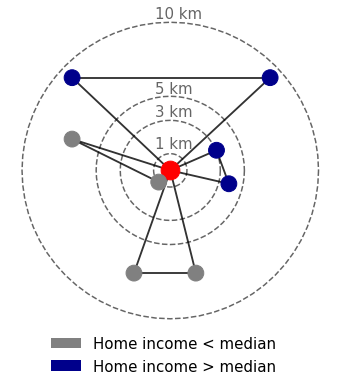

In [27]:
# example user
fig,ax = plt.subplots(1,1, figsize=(8,6))

# home point
point_home.plot(ax=ax, color=(1.0, 0.0, 0.0), marker='o', markersize=350, zorder=3, label = 'Home location')

# edges
lines_home.plot(ax=ax, alpha=0.8, color='black', linewidth=1.85, zorder=2)
third_df.plot(ax=ax, alpha=0.8, color='black', linewidth=1.85, zorder=2)

# homes of friends
friend_homes.plot(ax=ax, color= friend_homes["color"],markersize=250, zorder=3, label = 'Home of friends')

# circles
circle0 = point_home.to_crs(crs_3857)
circle0 = circle0.buffer(2250).boundary
circle0 = circle0.to_crs(crs_4326)
circle0.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5, alpha=0.6)

circle1 = point_home.to_crs(crs_3857)
circle1 = circle1.buffer(6750).boundary
circle1 = circle1.to_crs(crs_4326)
circle1.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5, alpha=0.6)

circle = point_home.to_crs(crs_3857)
circle = circle.buffer(10000).boundary
circle = circle.to_crs(crs_4326)
circle.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5, alpha=0.6)

circle2 = point_home.to_crs(crs_3857)
circle2 = circle2.buffer(20000).boundary
circle2 = circle2.to_crs(crs_4326)
circle2.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5, alpha=0.6)

ax.axis('off')
custom_lines = [Patch(facecolor='grey'), Patch(facecolor='darkblue')]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 0.15),
    ncol=1, frameon=False, fontsize=15)

ax.annotate('1 km', xy = (-71.2,42.382), size = 15, alpha = 0.6)
ax.annotate('3 km', xy = (-71.2,42.41), size = 15, alpha = 0.6)
ax.annotate('5 km', xy = (-71.2,42.431), size = 15, alpha = 0.6)
ax.annotate('10 km', xy = (-71.2,42.498), size = 15, alpha = 0.6)

plt.show()

### Figure 2 - concentration of social ties around home location of users

In [12]:
# data construction for subplots
def data_construction(df, col_selection, multi):
    rownames = []
    means = []
    type = list(["poor"] *20) + list(["rich"] *20)

    if multi == True:
        # loop to construct the dataframe
        for t in pr:        
            # table and columns to use
            temp = df[df["poor"]==pr[t]]
            temp = temp.loc[:, temp.columns.isin(col_selection)]

            # multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16..)
            x = 0.5**2*np.pi*np.linspace(1,39,20)

            # loop for variables
            for idx, c in enumerate(list(temp.columns)):
                rownames.append(str(c))
                means.append((np.mean(temp[str(c)]) * 1/x[idx]))   # area of the circle defined in the baseline 0.5*0.5*pi area
        
    else: 
        # loop to construct the dataframe
        for t in pr:

            # table and columns to use
            temp = df[df["poor"]==pr[t]]
            temp = temp.loc[:, temp.columns.isin(col_selection)]

            # loop for variables
            for c in list(temp.columns):
                rownames.append(str(c))
                means.append(np.mean(temp[str(c)]))


    fig_data = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})
    return fig_data

In [16]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

# fig a
pr = {"poor" : 1, "rich" : 0}
col_filter1 = ['dcum500_share','dcum1000_share', 'dcum1500_share','dcum2000_share', 'dcum2500_share', 'dcum3000_share', 'dcum3500_share', 'dcum4000_share',  'dcum4500_share', 'dcum5000_share', 'dcum5500_share','dcum6000_share', 'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share', 'dcum8500_share', 'dcum9000_share', 'dcum9500_share', 'dcum10000_share']
fig_a = data_construction(degree_tab, col_filter1, multi=False)

# fig b
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]
for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]
degree_tab = degree_tab.fillna(0)
col_filter2 = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']
fig_b = data_construction(degree_tab, col_filter2, multi=False)

# fig c
col_filter3 = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000', 'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']
fig_c = data_construction(degree_tab, col_filter3, multi=True)

In [22]:
def figure2a_plot(data, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(data["dist"][:20], data[data["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
    ax.plot(data["dist"][20:], data[data["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
    ax.set_xticklabels(labels)
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)

    ax.set_xlabel("Distance from home (km)", size=20)
    ax.set_ylabel("Cummulative share of friends",  size=20)
    ax.grid()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 

In [24]:
def figure2b_plot(data, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(data["dist"][:20], data[data["type"]=="poor"]["mean"], "o--", color="grey", linewidth=3, markersize=10, alpha=0.75)
    ax.plot(data["dist"][20:], data[data["type"]=="rich"]["mean"], "o--", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
    ax.set_xticklabels(labels)
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)

    ax.set_xlabel("Distance from home (km)", size=20)
    ax.set_ylabel("Share of friends",  size=20)
    ax.grid()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 

In [26]:
def figure2c_plot(data, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(data["dist"][:20], data[data["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
    ax.plot(data["dist"][20:], data[data["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
    ax.set_xticklabels(labels)
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    ax.set_xlabel("Distance from home (km)", size=20)
    ax.set_ylabel("Spatial density $(friends/km^2)$",  size=20)
    ax.grid()

<ipython-input-22-32a0f66fe510>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-24-4aac4aeab8ee>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-26-e4bd8979b8b6>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


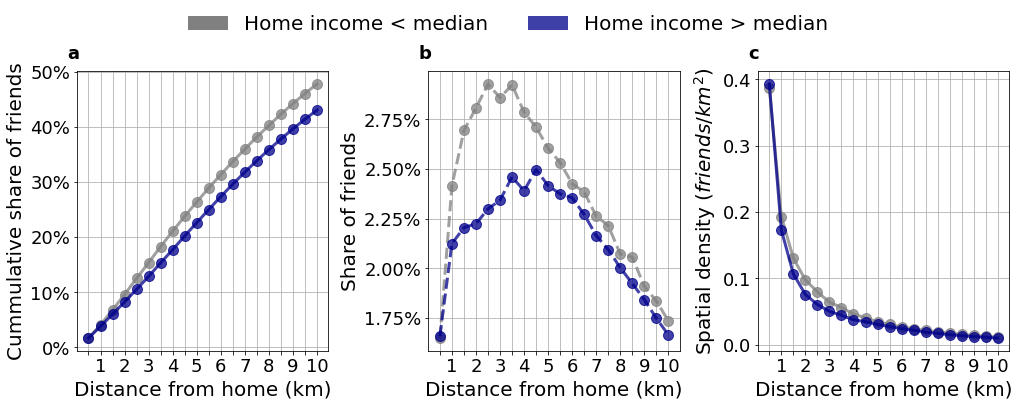

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (14, 5), constrained_layout=True, sharex=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))

figure2a_plot(fig_a, ax[0])
figure2b_plot(fig_b, ax[1])
figure2c_plot(fig_c, ax[2])

# legend
custom_lines = [Patch(facecolor='grey'), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.125),
    ncol=2, frameon=False, fontsize=20)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')

plt.show()

### Figure 3 - structural features of individual social capital in 10 km

In [4]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

# clustering data
clust_tab = pd.read_csv("../data/clust_tab_top50.csv.gz")
input_data = pd.merge(
    clust_tab,
    degree_tab,
    on="user_id",
    how="left"
)

# support data
supp_tab = pd.read_csv("../data/supp_tab_top50.csv.gz")
input_data = pd.merge(
    supp_tab,
    input_data,
    on="user_id",
    how="left"
)

In [5]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [49]:
def data_for_barplots(data, col_selection, version):
    rownames = []
    means = []
    upper = []
    lower = []
    error_lower  = []
    error_upper =[]
    pr = {"poor" : 1, "rich" : 0}
    type = list(["poor"] *4) + list(["rich"] *4)

    # loop to construct the dataframe
    for t in pr:
        # table and columns to use
        temp = data[data["poor"]==pr[t]]
        temp = temp.loc[:, temp.columns.isin(col_selection)]

        # loop for variables
        for c in list(temp.columns):
            rownames.append(str(c))
            
            if version=="degree":
                bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 4000)   # change repetition HERE
            else:    
                bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 4000)   # change repetition HERE

            means.append(np.mean(bootstrap_mean))
            lower.append(np.percentile(bootstrap_mean, 2.5))
            upper.append(np.percentile(bootstrap_mean, 97.5))
            error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
            error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
        
    result_df = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})
    return result_df

In [56]:
# figure 3 data construction
col_filter1 = ['dcum1000_share', 'dcum3000_share', 'dcum5000_share', 'dcum10000_share']
data_3a = data_for_barplots(input_data, col_filter1, version="degree")

col_filter2 = ['clust1000', 'clust3000', 'clust5000', 'clust10000']
data_3b = data_for_barplots(input_data, col_filter2, version="clust")

col_filter3 = ['support1000', 'support3000', 'support5000', 'support10000']
data_3c = data_for_barplots(input_data, col_filter3, version="support")

In [68]:
def figure3_plot(df, y_title, lim_list, ax=None):
    if ax is None:
        ax = plt.gca()
    X = np.arange(4)
    bar_width = 0.35
    a_poor = df[df["type"]=="poor"]
    a_rich = df[df["type"]=="rich"]
    rects1 = ax.bar(X, a_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [a_poor["error_lower"], a_poor["error_upper"]], capsize = 10, alpha=0.75)
    rects2 = ax.bar(X + bar_width, a_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [a_rich["error_lower"], a_rich["error_upper"]], capsize = 10, alpha=0.75) 
    ax.set_ylabel(y_title, size=20)
    ax.set_xlabel(xlabel='Distance from home', size=20)
    ax.set_xticks(X + bar_width/2)
    ax.set_xticklabels(['1 km', '3 km', '5 km', '10 km'])
    ax.set_ylim(lim_list)

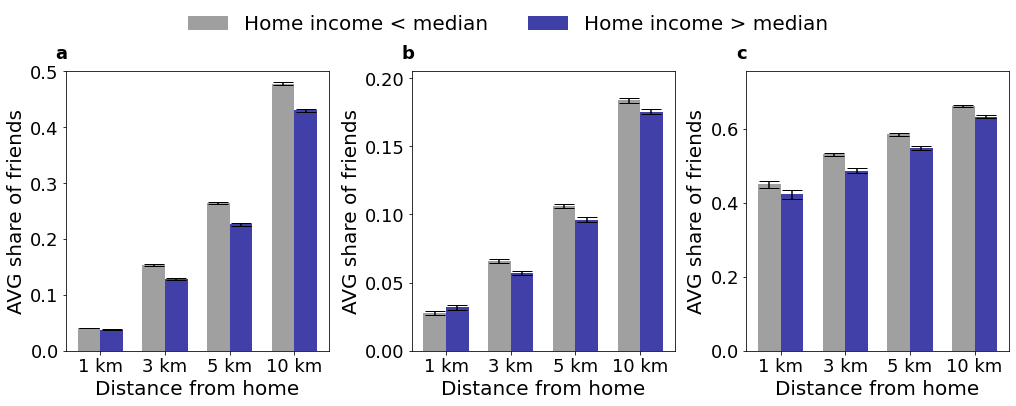

In [69]:
fig, ax = plt.subplots(1, 3, figsize = (14, 5), constrained_layout=True, sharex=True)
plt.rcParams['font.size']=18

titles = ['1 km', '3 km', '5 km', '10 km']
colorsList = ["grey", "darkblue"]

figure3_plot(data_3a, "AVG share of friends", [0, 0.5], ax[0])
figure3_plot(data_3b, "AVG share of friends", [0, 0.205], ax[1])
figure3_plot(data_3c, "AVG share of friends", [0, 0.755], ax[2])

# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.125),
    ncol=2, frameon=False, fontsize=20)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')

plt.show()

### Figure 4 - controlled correlations

In [77]:
# metrodata transformation
metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").reset_index().sort_values(by="CENSUS2010POP", ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank", "CBSA":"cbsacode", "NAME":"name", "CENSUS2010POP":"population"}, axis=1, inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

# top 50 ONLY
metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.iloc[:50,]
metrodata = metrodata.reset_index()

In [80]:
# regression coefficients - output of "../notebooks/regressions.R"
codf = pd.read_csv("../data/coeff_df.csv", sep=";")

# merge
plotdata = pd.merge(metrodata, codf, left_on="cbsacode", right_on="cbsalist", how="left")
plotdata = plotdata.sort_values(by="population", ascending=True)

In [83]:
# column for colors -- significant / not significant issuue
plotdata['col_deg'] = [(0.0, 0.0, 0.5450980392156862) if (x > 0 and x-1.96*y > 0) else (0.5019607843137255, 0.5019607843137255, 0.5019607843137255) if (x < 0 and x + 1.96*y < 0) else (0.0, 0.0, 0.5450980392156862,0.5) if (x > 0 and x-1.96*y < 0) else (0.5019607843137255, 0.5019607843137255, 0.5019607843137255,0.5) for x,y in zip(plotdata['icoeff_deg'],plotdata['ise_deg'])]
plotdata['col_clust'] = [(0.0, 0.0, 0.5450980392156862) if (x > 0 and x-1.96*y > 0) else (0.5019607843137255, 0.5019607843137255, 0.5019607843137255) if (x < 0 and x + 1.96*y < 0) else (0.0, 0.0, 0.5450980392156862,0.5) if (x > 0 and x-1.96*y < 0) else (0.5019607843137255, 0.5019607843137255, 0.5019607843137255,0.5) for x,y in zip(plotdata['icoeff_clust'],plotdata['ise_clust'])]
plotdata['col_supp'] = [(0.0, 0.0, 0.5450980392156862) if (x > 0 and x-1.96*y > 0) else (0.5019607843137255, 0.5019607843137255, 0.5019607843137255) if (x < 0 and x + 1.96*y < 0) else (0.0, 0.0, 0.5450980392156862,0.5) if (x > 0 and x-1.96*y < 0) else (0.5019607843137255, 0.5019607843137255, 0.5019607843137255,0.5) for x,y in zip(plotdata['icoeff_supp'],plotdata['ise_supp'])]

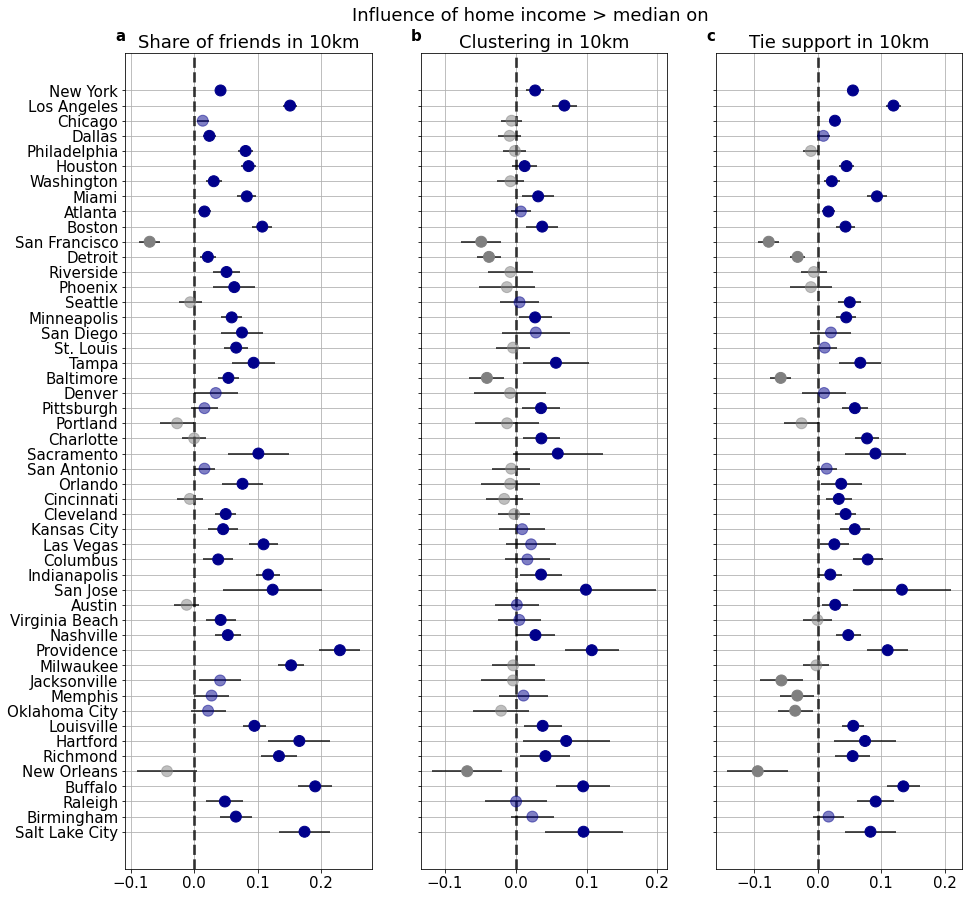

In [84]:
# plot
fig,ax = plt.subplots(1,3,figsize=(15,15), sharey=True)
plt.rcParams['font.size']=15

ax[0].scatter(plotdata['icoeff_deg'], plotdata['short_name'], c=plotdata["col_deg"], marker='o', s=120, zorder=3)
ax[0].hlines(xmin=(plotdata['icoeff_deg']-(1.96*plotdata['ise_clust'])), xmax=(plotdata['icoeff_deg']+(1.96*plotdata['ise_clust'])), y=plotdata['short_name'], color='black', alpha=0.9)
ax[0].axvline(linewidth=2.75, color='black', alpha=0.75, linestyle='dashed', zorder=2)
ax[0].grid()
ax[0].set_title("Share of friends in 10km")

ax[1].scatter(plotdata['icoeff_clust'], plotdata['short_name'], color=plotdata["col_clust"], marker='o', s=120, zorder=3)
ax[1].hlines(xmin=(plotdata['icoeff_clust']-(1.96*plotdata['ise_deg'])), xmax=(plotdata['icoeff_clust']+(1.96*plotdata['ise_deg'])), y=plotdata['short_name'], color='black', alpha=0.9)
ax[1].axvline(linewidth=2.75, color='black', alpha=0.75, linestyle='dashed', zorder=2)
ax[1].grid()
ax[1].set_title("Clustering in 10km")

ax[2].scatter(plotdata['icoeff_supp'], plotdata['short_name'], color=plotdata["col_supp"], marker='o', s=120, zorder=3)
ax[2].hlines(xmin=(plotdata['icoeff_supp']-(1.96*plotdata['ise_supp'])), xmax=(plotdata['icoeff_supp']+(1.96*plotdata['ise_supp'])), y=plotdata['short_name'], color='black', alpha=0.9)
ax[2].axvline(linewidth=2.75, color='black', alpha=0.75, linestyle='dashed', zorder=2)
ax[2].grid()
ax[2].set_title("Tie support in 10km")

fig.text(0.5, 0.91, 'Influence of home income > median on', ha='center', size=18)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')

plt.show()

### Figure 5 - Homophily among the social networks of users in 10 km

In [2]:
# edgelist with income data
edge_table = pd.read_csv("../data/edgelist_geoinfo.csv.gz")

# degree data
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz").set_index('user_id')

# above / below median friends
pr_ties = pd.read_csv("../data/pr_friends_stats.csv.gz")

In [3]:
# create nr poor ties var
temp = edge_table[edge_table["poor2"]==1]
degree_tab["poor_ties"] = degree_tab.index.map(temp.groupby("user_id1")["user_id2"].agg("count").to_dict())
degree_tab = degree_tab.reset_index()

# share of poor / rich ties
degree_tab["share_poor_ties"] = degree_tab["poor_ties"] / degree_tab["degree"]
degree_tab["share_rich_ties"] = 1 - (degree_tab["poor_ties"] / degree_tab["degree"])

In [4]:
# cells of degree heatmap
pp = np.round(degree_tab[degree_tab["poor"]==1]["share_poor_ties"].mean(),2)
pr = np.round(degree_tab[degree_tab["poor"]==1]["share_rich_ties"].mean(),2)
rp = np.round(degree_tab[degree_tab["poor"]==0]["share_poor_ties"].mean(),2)
rr = np.round(degree_tab[degree_tab["poor"]==0]["share_rich_ties"].mean(),2)

# cells of clustering heatmap
pp_c = np.round(pr_ties[pr_ties["poor"]==1]["clust_poor"].mean(),2)
pr_c = np.round(pr_ties[pr_ties["poor"]==1]["clust_rich"].mean(),2)
rp_c = np.round(pr_ties[pr_ties["poor"]==0]["clust_poor"].mean(),2)
rr_c = np.round(pr_ties[pr_ties["poor"]==0]["clust_rich"].mean(),2)

# cells of support heatmap
pp_s = np.round(pr_ties[pr_ties["poor"]==1]["support_poor"].mean(),2)
pr_s = np.round(pr_ties[pr_ties["poor"]==1]["support_rich"].mean(),2)
rp_s = np.round(pr_ties[pr_ties["poor"]==0]["support_poor"].mean(),2)
rr_s = np.round(pr_ties[pr_ties["poor"]==0]["support_rich"].mean(),2)

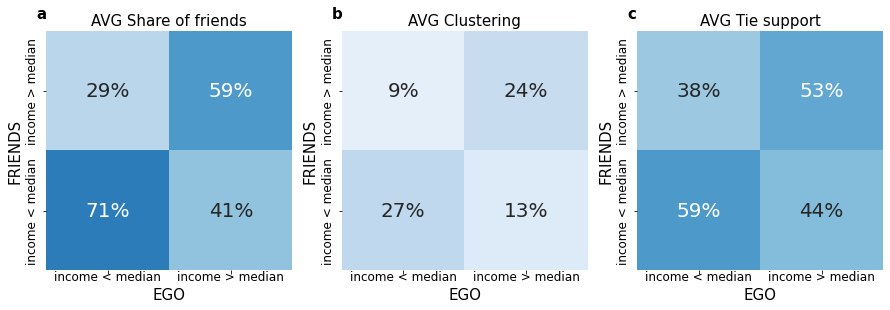

In [11]:
# heatmaps for figure 5
fig,ax = plt.subplots(1,3, figsize=(15,4.4))

# create a 2x2 ndarray -- degree
l1 = [pr*100, rr*100, pp*100, rp*100]
columns = 2
rows = 2
grid = np.ndarray((2, 2));
listIndex = 0

# fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l1[listIndex];
        listIndex = listIndex+1;

# create a heatmap and display
g = sns.heatmap(grid,
    annot=True,
    annot_kws={"fontsize":20},
    fmt="g",
    xticklabels = ["income < median", "income > median"],
    yticklabels = ["income > median", "income < median"],
    vmin=0,
    vmax=100,
    cmap="Blues",
    ax = ax[0],
    cbar=False)

g.set_yticklabels(labels=g.get_yticklabels(), va='center', size = 12)
g.set_xticklabels(labels=g.get_xticklabels(), va='center', size = 12)
g.set_xlabel("EGO", size = 15)
g.set_ylabel("FRIENDS", size = 15)
ax[0].set_title('AVG Share of friends', size = 15)
for t in g.texts: t.set_text(t.get_text() + "%")


# create a 2x2 ndarray -- clustering
l2 = [pr_c*100, rr_c*100, pp_c*100, rp_c*100]
grid = np.ndarray((2, 2));
listIndex = 0

# fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l2[listIndex];
        listIndex = listIndex+1;

# create a heatmap and display
h = sns.heatmap(grid,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels = ["income < median", "income > median"],
    yticklabels = ["income > median", "income < median"],
    ax = ax[1],
    vmin=0,
    vmax=100,
    cbar=False,
    annot_kws={"fontsize":20})

h.set_yticklabels(labels=h.get_yticklabels(), va='center', size = 12)
h.set_xticklabels(labels=h.get_xticklabels(), va='center', size = 12)
h.set_xlabel("EGO", size = 15)
h.set_ylabel("FRIENDS", size = 15)
ax[1].set_title('AVG Clustering', size = 15)
for t in h.texts: t.set_text(t.get_text() + "%")


# create a 2x2 ndarray -- support
l3 = [pr_s*100, rr_s*100, pp_s*100, rp_s*100]
grid = np.ndarray((2, 2));
listIndex = 0;

# fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l3[listIndex];
        listIndex = listIndex+1;

# create a heatmap and display
i = sns.heatmap(grid,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels = ["income < median", "income > median"],
    yticklabels = ["income > median", "income < median"],
    ax = ax[2],
    cbar=False,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize":20})

i.set_yticklabels(labels = i.get_yticklabels(), va='center', size = 12)
i.set_xticklabels(labels = i.get_xticklabels(), va='center', size = 12)
i.set_xlabel("EGO", size = 15)
i.set_ylabel("FRIENDS", size = 15)
ax[2].set_title('AVG Tie support', size = 15)
for t in i.texts: t.set_text(t.get_text() + "%")

for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold', size = 15)

plt.show()